In [1]:
!pip install mglearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn

In [2]:
citibike = mglearn.datasets.load_citibike()

In [3]:
print("Citi Bike Data:\n{}".format(citibike.head()))

Citi Bike Data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


Text(0, 0.5, 'Rentals')

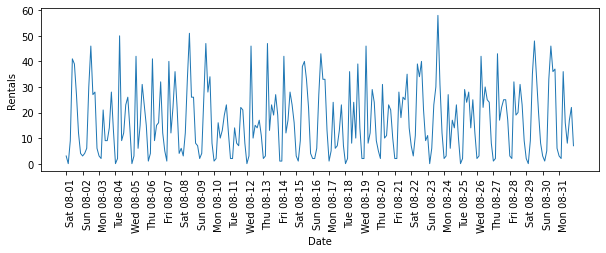

In [4]:
# Visualization of the rental frequencies for the whole month
plt.figure(figsize=(10 ,3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

In [5]:
# When evaluating a prediction task on a time-series like this, we usually want to learn from the past and predict for the future.

# This means while splitting our dataset into traning and testing datasets we want to splt the data for training set up to a certain date 
# and all the data past that date as the testing set.

# We will use the first 184 data points corresponding to the first 23 days, as our training set and the remaining 64 data points 
# corresponding to the last 8 days as the testing set.

# The only feature that we will be using for the predicition task is then date and time when a particular number of rentals occured. So the
# input feature is the data and time and the output is the number of rentals in the following three hours. (3 in our case, acc to Dataframe)

# Common way to store dates on computers is using POSIX time, which is the number of seconds since January 1970 00:00:00(aka the beginning
# of the Unix time).

# As a first try, we can use this single integer feature as our data representation

In [6]:
# Extracting the target values (number of rentals)
y = citibike.values

# Converting the time to POSIX using "%s"
X = citibike.index.strftime("%s").astype("int").values.reshape(-1, 1)

In [7]:
# Using the first 184 data points for training, and the rest for testing
n_train = 184

# Function to evaluate and plot a regressor on a given feature set

def eval_on_features(features, target, regressor):

  # Splitting the data into training and testing set
  X_train, X_test = features[:n_train], features[n_train:]

  # Also splitting the target array
  y_train, y_test = target[:n_train], target[n_train:]
  regressor.fit(X_train, y_train)

  print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
  y_pred = regressor.predict(X_test)
  y_pred_train = regressor.predict(X_train)
  plt.figure(figsize=(10, 3))
  plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")

  plt.plot(range(n_train), y_train, label="Train")
  plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="Test")
  plt.plot(range(n_train), y_pred_train, '--', label="Prediction Train")

  plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="Prediction Test")
  plt.legend(loc=(1.01, 0))
  plt.xlabel("Date")
  plt.ylabel("Rentals")

Test-set R^2: -0.04


<Figure size 432x288 with 0 Axes>

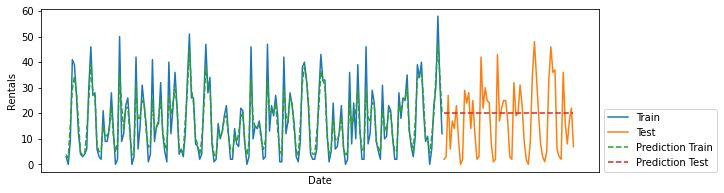

In [8]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()
eval_on_features(X, y, regressor)

In [9]:
# The testing set has data points or dates and times later than the ones in the training set. Trees and therefore random forests cannot 
# extrapolate to feature ranges outside the training set.

# The result is that the model simply predicts the target value of the closest point in the training set- which is the last time it observed
# any data.

In [10]:
# Clearly we want to better than this. This is where our "Expert Knowledge" comes in. From looking at the rental figures in the training
# data, 2 factors seem to be very important they are time of the day and day of the week. Let's add thest 2 features.

# We can't really learn anything from this 2 POSIX time, so we drop that feature. First. let's use only hour of the day.

Test-set R^2: 0.60


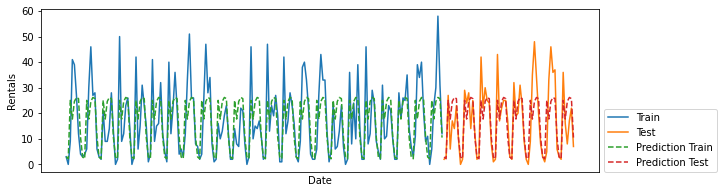

In [11]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

Test-set R^2: 0.84


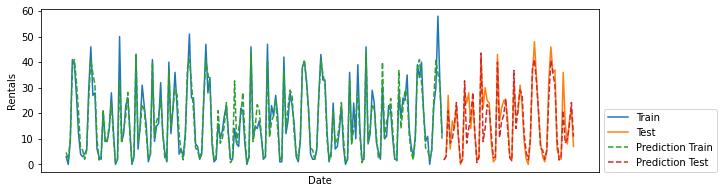

In [12]:
# As you can see, now the predictions have the same pattern for each day of the week. The R^2 is already much better but the predicitions
# clearly miss the weakly pattern. Now let's add the day of the week.

X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])

eval_on_features(X_hour_week, y, regressor)

In [13]:
# Now we have a model that captures the periodic behavior by considering the day of the week and time of the day. It has an R^2 of 0.84 
# and shows pretty good predictive performance. What this model likely is learning is the mean number of rentals for each combination of
# weekday and time of day from the first 23 days of August.

# This actually does not require a complex model like Random Forst, so we will try LinearRegression

Test-set R^2: 0.13


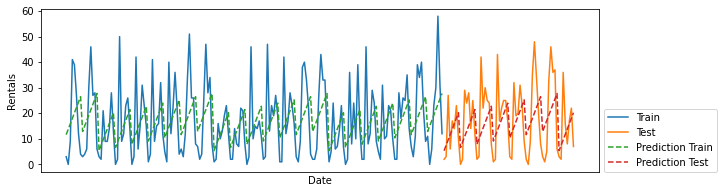

In [14]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

In [15]:
# LinearRegression works much worse and the periodic pattern looks odd. The reason for this is that we have encoded day of the week and
# time of the day using integers, which are interpreted as categorical variables.

# Therefore the linear model can only learn a linear function of the time of day, and it learned that later in the day, there are more
# rentals. However the patters are much more complex than that.

# We can capture this by interpreting the integers as categorical variables, by transforming them using OneHotEncoder

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

Test-set R^2: 0.62


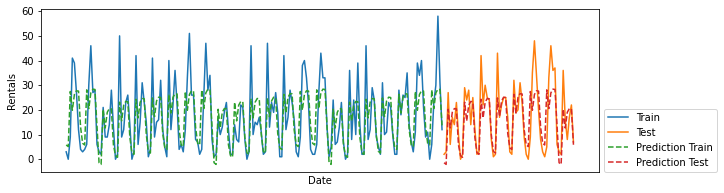

In [17]:
eval_on_features(X_hour_week_onehot, y, Ridge())

In [18]:
# This gives us a much better match than the continous feature encoding. Now the linear model learns one coefficient for each day of the 
# week, and one coefficient for each time of the day. That means that the "time of the day" pattern is shared over all days of the week,
# though.

Test-set R^2: 0.85


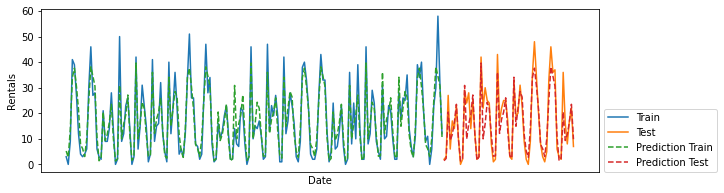

In [19]:
# Using interaction features, we can allow the model to learn one coefficient for each combination of day and time of the day.
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [20]:
# This transformation finally  yields a model that performs similarly well to the random forest. A big benefit of this model is that it
# is very clear what is learned: one coefficient for each day and time. We can simply plot the coefficients learned by the model,
# something that would not be possible for the random forest.

In [21]:
# First we create features names for the hour and the day features:

hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour

In [22]:
# Now we will name all the features extracted by PolynomialFeatures, using the get_features_names method, and keep only the features with
# non-zero coefficients.

features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

Text(0, 0.5, 'Feature')

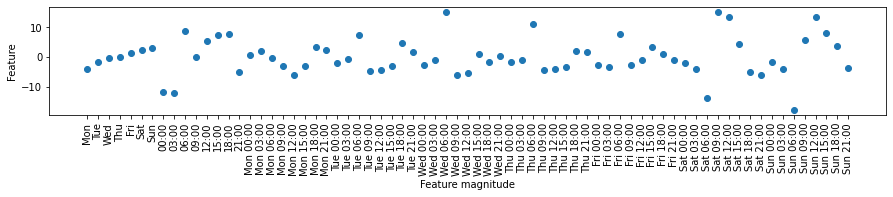

In [23]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature magnitude")
plt.ylabel("Feature")